# Modeling the 62 Manhattan zones

__In this notebook, I will explore various predictive models to forecast the pick-up trips in the 62 areas of the city of Manhattan. I Will save then the best model to use it in the forecasting application which we will develop later.
Note that we will develop seperate nueral network model to forecast the pick-up trips in the top 5 zones.__

* First, I will create a baseline model by calculating the average of pickups per zone and per hour.

* After that, I will use some regression models to compare with the baseline model and select the best one.

* Finally I will pack de model using pickle so I can use it in the front end.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from xgboost import  XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_error
import pickle

In [2]:
Manhattan=pd.read_csv('Manhattan.csv')

In [4]:
Manhattan.head()

,timestamp,LocationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,Borough,Zone,temp,humidity,precip,snow,windspeed,Holiday,IsWeekend
0,2020-01-01 00:00:00,263,390,301,2020,1,1,0,4,Manhattan,Yorkville West,5.1,58.68,0.0,0.0,19.6,1.0,0
1,2020-01-01 00:00:00,262,149,236,2020,1,1,0,4,Manhattan,Yorkville East,5.1,58.68,0.0,0.0,19.6,1.0,0
2,2020-01-01 00:00:00,261,51,62,2020,1,1,0,4,Manhattan,World Trade Center,5.1,58.68,0.0,0.0,19.6,1.0,0
3,2020-01-01 00:00:00,249,419,173,2020,1,1,0,4,Manhattan,West Village,5.1,58.68,0.0,0.0,19.6,1.0,0
4,2020-01-01 00:00:00,246,214,152,2020,1,1,0,4,Manhattan,West Chelsea/Hudson Yards,5.1,58.68,0.0,0.0,19.6,1.0,0


In [5]:
Manhattan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368408 entries, 0 to 1368407
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   timestamp         1368408 non-null  object 
 1   LocationID        1368408 non-null  int64  
 2   Pick_Trips_count  1368408 non-null  int64  
 3   Drop_Trips_count  1368408 non-null  int64  
 4   Year              1368408 non-null  int64  
 5   Month             1368408 non-null  int64  
 6   DayOfMonth        1368408 non-null  int64  
 7   Hour              1368408 non-null  int64  
 8   dayofweek         1368408 non-null  int64  
 9   Borough           1368408 non-null  object 
 10  Zone              1368408 non-null  object 
 11  temp              1368408 non-null  float64
 12  humidity          1368408 non-null  float64
 13  precip            1368408 non-null  float64
 14  snow              1368408 non-null  float64
 15  windspeed         1368408 non-null  float64
 16  

__We will remove the top 5 Manhattan zones.__

In [6]:
top_locations=['237','236','161','186','162']

In [7]:
top_locations=[237,236,161,186,162]

In [8]:
#filter for rows where team name is not in list
Manhattan_remaining=Manhattan[~Manhattan['LocationID'].isin(top_locations)]

In [9]:
Manhattan_remaining = Manhattan_remaining.reset_index(drop=True)

In [10]:
len(Manhattan_remaining)

1266288

In [11]:
Manhattan_remaining['LocationID'].nunique()

62

__Now we will drop the unnecessary columns which we dont need__

In [12]:
drop_columns=['timestamp','Drop_Trips_count','Borough','Zone']

In [13]:
Manhattan_remaining.drop(drop_columns, inplace=True, axis=1)

In [14]:
Manhattan_remaining.head()

,LocationID,Pick_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,temp,humidity,precip,snow,windspeed,Holiday,IsWeekend
0,263,390,2020,1,1,0,4,5.1,58.68,0.0,0.0,19.6,1.0,0
1,262,149,2020,1,1,0,4,5.1,58.68,0.0,0.0,19.6,1.0,0
2,261,51,2020,1,1,0,4,5.1,58.68,0.0,0.0,19.6,1.0,0
3,249,419,2020,1,1,0,4,5.1,58.68,0.0,0.0,19.6,1.0,0
4,246,214,2020,1,1,0,4,5.1,58.68,0.0,0.0,19.6,1.0,0


## Scaling the data

In [15]:
# split the data X, y
X = Manhattan_remaining.drop('Pick_Trips_count', axis=1)
y = Manhattan_remaining['Pick_Trips_count']

In [16]:
# Split TRAIN-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

__We will fit the scaler on the train data only to avoid data leakage__

In [18]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [19]:
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns)

In [20]:
print('X_train: {0} ({1}%)'.format(scaled_X_train.shape[0], round((scaled_X_train.shape[0]/X.shape[0])*100),2))
print('y_train: {0} ({1}%)'.format(y_train.shape[0], round((y_train.shape[0]/X.shape[0])*100),2))
print('X_test: {0} ({1}%)'.format(scaled_X_test.shape[0], round((scaled_X_test.shape[0]/X.shape[0])*100),2))
print('y_test: {0} ({1}%)'.format(y_test.shape[0], round((y_test.shape[0]/X.shape[0])*100),2))

X_train: 1013030 (80%)
y_train: 1013030 (80%)
X_test: 253258 (20%)
y_test: 253258 (20%)


__The following functions will help us to obtain the performance metrics and make comparison plots between different models__

In [58]:
def get_metrics(model_name, y_real, y_pred):
    
    # MAE: Mean Absolute error,same units as target variable.
    MAE = mean_absolute_error(y_real, y_pred)
    
    # MAE: Mean square error
    MSE = mean_squared_error(y_real, y_pred)

    # RMSE: Root Mean square error,same units as target variable
    RMSE = np.sqrt(mean_squared_error(y_real, y_pred))
    
    # R2: R-Square (Coefficient of determination)
    R2 = round((r2_score(y_real, y_pred)*100),2)
       
    print('MODEL: ', model_name)
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    print('RMSE: ', RMSE)
    print('R-Square (Coefficient of determination): ', R2,' %')
    
    return model_name,MAE,MSE, RMSE, R2

In [133]:
def compare_model_metrics(mod_metric_list):
    
    plt.style.use('tableau-colorblind10')
    
    # create DataFrames with metric data
    df_MAE = pd.DataFrame(columns=['MAE'])
    df_MAE_index = []
    df_MSE = pd.DataFrame(columns=['MSE'])
    df_MSE_index = []
    df_RMSE = pd.DataFrame(columns=['RMSE'])
    df_RMSE_index = []
    df_R2 = pd.DataFrame(columns=['R2'])
    df_R2_index = []

    
    for mod in mod_metric_list:
        df_MAE = df_MAE.append({'MAE': mod[1]}, ignore_index=True)
        df_MAE_index.append(mod[0])
        df_MSE = df_MSE.append({'MSE': mod[2]}, ignore_index=True)
        df_MSE_index.append(mod[0])
        df_RMSE = df_RMSE.append({'RMSE': mod[3]}, ignore_index=True)
        df_RMSE_index.append(mod[0])
        df_R2 = df_R2.append({'R2': mod[4]}, ignore_index=True)
        df_R2_index.append(mod[0])

    
    # set index names so they appear y the bar plot
    df_MAE.index = df_MAE_index
    df_MSE.index = df_MSE_index
    df_RMSE.index = df_RMSE_index
    df_R2.index = df_R2_index
    
    
    # sort values so the best model appears in first position
    df_MAE = df_MAE.sort_values('MAE', ascending=False)
    df_MSE = df_MSE.sort_values('MSE', ascending=False)
    df_RMSE = df_RMSE.sort_values('RMSE', ascending=False)
    df_R2 = df_R2.sort_values('R2', ascending=True)
    
    
    # create figure and one axis per metric
    f = plt.figure(figsize=(10,len(mod_metric_list*3)))
    axes1 = f.add_subplot(4,1,1)
    axes2 = f.add_subplot(4,1,2)
    axes3 = f.add_subplot(4,1,3)
    axes4 = f.add_subplot(4,1,4)
    
    # plot dataframes with DataFrame.plot()
    df_MAE.plot(kind='barh',ax=axes1, title = 'Compare Model Metrics', color='lightgrey')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
        
    df_MSE.plot(kind='barh',ax=axes2,color='lightgreen').legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
            
    df_RMSE.plot(kind='barh', ax=axes3, color='lightskyblue')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
            
    df_R2.plot(kind='barh', ax=axes4, color='lightpink')\
            .legend(loc='lower left',bbox_to_anchor=(1.0, 0.5))
            

    
    # annotate bars with result values 
    for p in axes1.patches:
        axes1.annotate(np.round(a=p.get_width(), decimals=1), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-35, 5), textcoords='offset points')

    for p in axes2.patches:
        axes2.annotate(np.round(a=p.get_width(), decimals=1), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-20, 5), textcoords='offset points')
    for p in axes3.patches:
        axes3.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-35, 5), textcoords='offset points')

    for p in axes4.patches:
        axes4.annotate(np.round(a=p.get_width(), decimals=3), \
                       (p.get_x() + p.get_width(), p.get_y()), \
                       xytext=(-35, 5), textcoords='offset points')
        
    plt.show()

In [98]:
def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('tableau-colorblind10')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

## 1- Baseline model

The baseline model will be the average of pickups counts per zone, per hour. I will use this model as baseline model and to compare with the rest of the models and try to improve the results.

In [25]:
x=Manhattan_remaining[['Hour', 'LocationID', 'Pick_Trips_count']]

In [26]:
Y=Manhattan_remaining[['Pick_Trips_count']]

In [27]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(x, Y, test_size=0.2, random_state=1)

In [28]:
basemodel = X_train_base.groupby(['Hour', 'LocationID']).mean()

In [29]:
basemodel

Pick_Trips_count
Hour LocationID                  
0    4                   6.971893
     12                  0.165468
     13                  3.428152
     24                  3.788856
     41                  6.429812
...                           ...
23   246                26.871111
     249               104.667606
     261                 8.735683
     262                11.563135
     263                53.167638

[1488 rows x 1 columns]

In [30]:
def basemodel_predict(base, X_test_base):
    # select columns of interest to use to get values from basemodel
    X_test_base = X_test_base[['Hour', 'LocationID']]
    #X_test = X_test.head(10)
    output = []
    
    # map average values from baseline model with validation data
    # append those values to output series
    for index, row in X_test_base.iterrows():
        output.append(int(base.loc[(row['Hour'], row['LocationID']), :]))

    output_array = np.asarray(output)
    return output_array

In [31]:
base_y_pred = basemodel_predict(basemodel, X_test_base)

MODEL:  Baseline Model
MAE:  21.889318402577608
MSE:  1936.1035347353293
RMSE:  44.001176515353876
R-Square (Coefficient of determination):  49.47  %


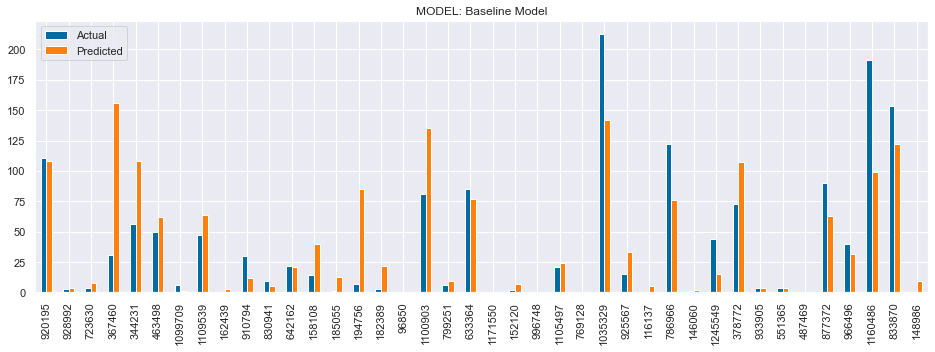

Text(0.5, 1.0, 'Baseline model: Actual vs Predicted')

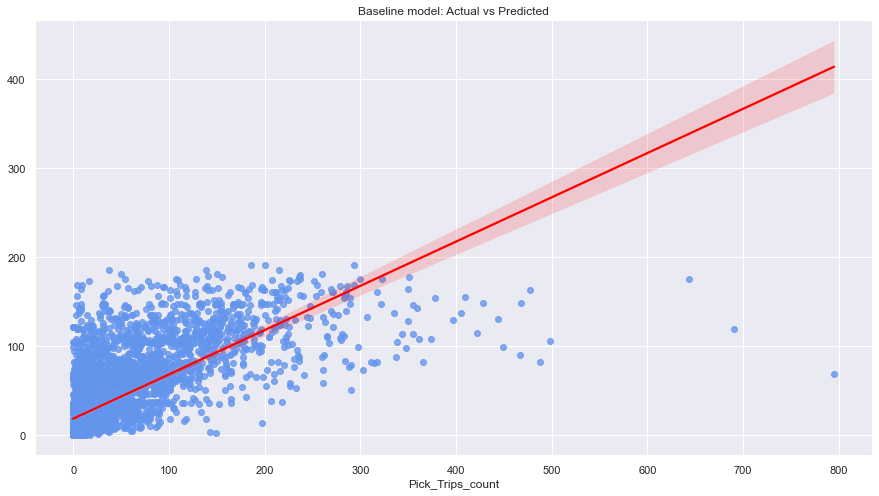

In [200]:
base_metrics = get_metrics('Baseline Model',y_test, base_y_pred)

plot_real_vs_pred('Baseline Model', y_test, base_y_pred)

sns.regplot(y_test.head(5000), base_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Baseline model: Actual vs Predicted')

### Conclusion:

__As a starting point, the baseline model gives "bad" results.
It allows us to predict 49% of the cases (R2 = 49%) with an error of 44 (RMSE).__

## 1- Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

__Since we going to use Linear Regression, we will use the scaled data__

In [45]:
# Create an instance of the model and train it
reg = LinearRegression()
reg.fit(scaled_X_train, y_train)

LinearRegression()

In [46]:
# Do predictions
LR_y_pred = reg.predict(scaled_X_test)

In [47]:
r2_score(y_test,LR_y_pred)

0.07965904059945661

In [48]:
np.round(reg.score(scaled_X_train, y_train),4)

0.0809

In [49]:
np.round(reg.score(scaled_X_test, y_test),4)

0.0797

In [50]:
# getting the evaluation matrics
linear_metrics = get_metrics('Linear Regression',y_test, LR_y_pred)

MODEL:  Linear Regression
MAE:  38.66961273804058
MSE:  3526.6680382365385
RMSE:  59.38575618981827
R-Square (Coefficient of determination):  7.97  %


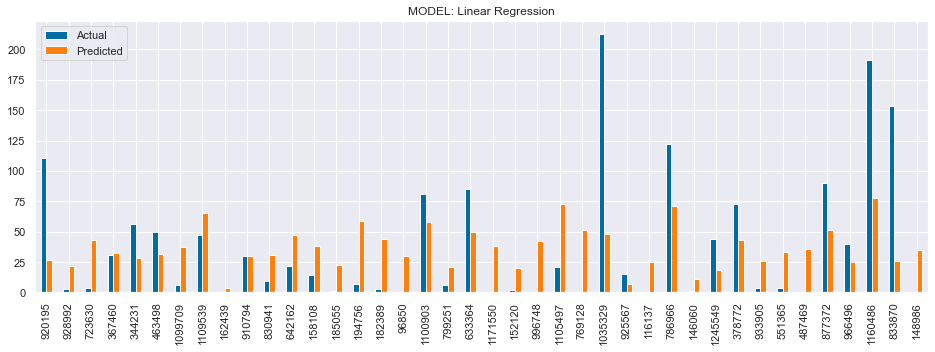

Text(0.5, 1.0, 'Linear Regression: Actual vs Predicted')

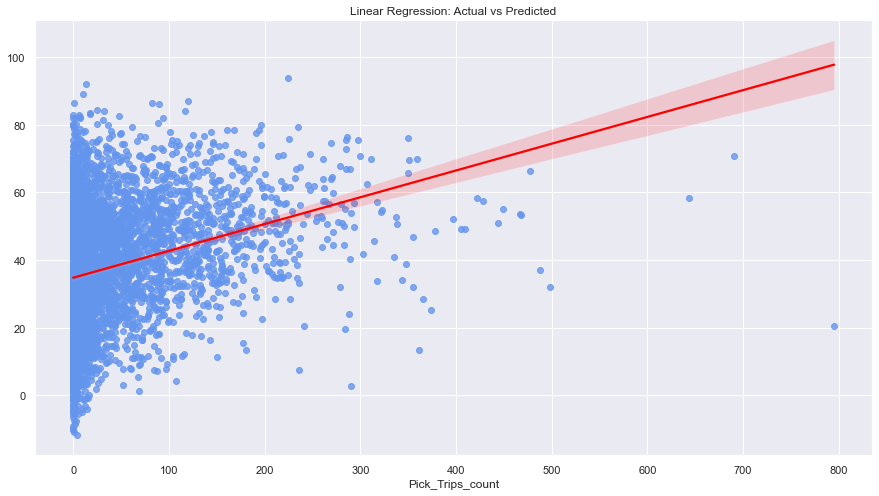

In [199]:
plot_real_vs_pred('Linear Regression', y_test, LR_y_pred)

sns.regplot(y_test.head(5000), LR_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Linear Regression: Actual vs Predicted')

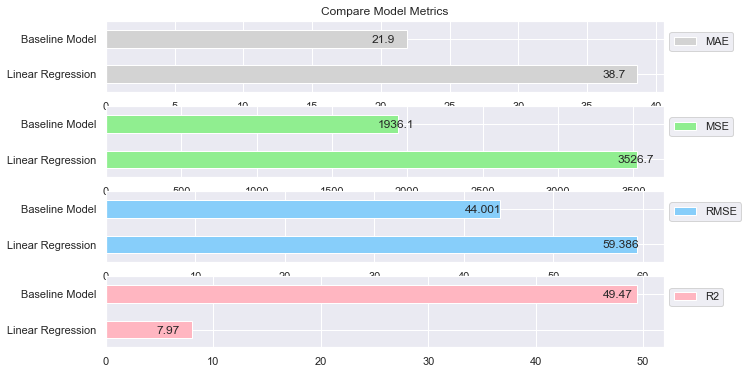

In [198]:
compare_model_metrics([base_metrics,linear_metrics])

### Conclusion:

__Based on the above graphs, I can see that Linear Regression Model predictions are worse than the baseline model.
The scatter plot shows a weak correlation between real values and predictions.__

## 2- Decision Tree Regressor

In [101]:
from sklearn.tree import DecisionTreeRegressor

__Since Decision Tree doesnt require the data to be scaled, then we will use the X_train data__.

Creating simple Decision Tree model

In [106]:
# Fitting regression tree to the Training set
Tree_regressor = DecisionTreeRegressor()
Tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor()

Exploring the default parameters

In [107]:
Tree_regressor.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [108]:
# Predicting the Test set results
DT_y_pred = Tree_regressor.predict(X_test)

In [110]:
DT_metrics = get_metrics('Decision tree',y_test, DT_y_pred)

MODEL:  Decision tree
MAE:  7.565478681818541
MSE:  273.81323393535445
RMSE:  16.54730292027539
R-Square (Coefficient of determination):  92.85  %


__We need to check if the model overfit or not, simple comparison between the train score and the test score can show us if the model is overfitted or not.__

- If the train score is 1, then the model is overfit

- If the gap between the train score and the test score is quit high, it means the model is overfit


_Lets explore the train score and the test score_

In [145]:
# training R2
np.round(Tree_regressor.score(X_train, y_train),4)

1.0

In [146]:
# test R2
np.round(Tree_regressor.score(X_test, y_test),4)

0.9297

__It seems that the model is overfit since the training R^2 equal 1__

we will tune the max depth only and min_samples_leaf using GridSearchCV

__Tuning the model__

In [152]:
grid_param={"max_depth":range(15,25,1),
           "min_samples_leaf":range(2,10,1)}

In [153]:
from sklearn.model_selection import GridSearchCV

In [154]:
regd_grid = GridSearchCV(DecisionTreeRegressor(),
                       param_grid=grid_param,
                       cv = 3,
                       scoring = "neg_mean_absolute_error")

In [155]:
regd_grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(15, 25),
                         'min_samples_leaf': range(2, 10)},
             scoring='neg_mean_absolute_error')

In [156]:
# Do predictions
DT_grid_y_pred = regd_grid.predict(X_test)

In [160]:
# getting the best tuned parameters
regd_grid.best_params_

{'max_depth': 24, 'min_samples_leaf': 4}

In [162]:
# refilling regression tree to the Training set
Tree_regressor_tuned = DecisionTreeRegressor(max_depth=24,min_samples_leaf= 4)
Tree_regressor_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=24, min_samples_leaf=4)

In [113]:
DT_tuned_y_pred = Tree_regressor_tuned.predict(X_test)

In [115]:
DT_metrics = get_metrics('Decision tree Tuned',y_test, DT_tuned_y_pred)

MODEL:  Decision tree Tuned
MAE:  6.913663955740301
MSE:  239.42642755204542
RMSE:  15.473410340065483
R-Square (Coefficient of determination):  93.75  %


__Checking again the train score and the test score__


In [167]:
# training R2
np.round(Tree_regressor_tuned.score(X_train, y_train),4)

0.9769

In [171]:
# test R2
np.round(Tree_regressor_tuned.score(X_test, y_test),4)

0.9375

In [186]:
# training R2
Tree_regressor_tuned.score(X_test, y_test)

0.9375178084100938

__We will perform K-fold cross validation to evaluate the model's ability when given new data__

we will choose 5 splits

In [172]:
cv=KFold(n_splits=5,shuffle=True)

In [173]:
# performing the KFold Cross-Validation
Tree_CV=cross_val_score(Tree_regressor_tuned,X, y,cv=cv)

In [174]:
print('CV average tuned decsion tree model score:',(Tree_CV.mean())*100,'%')

CV average tuned decsion tree model score: 94.18799817287183 %


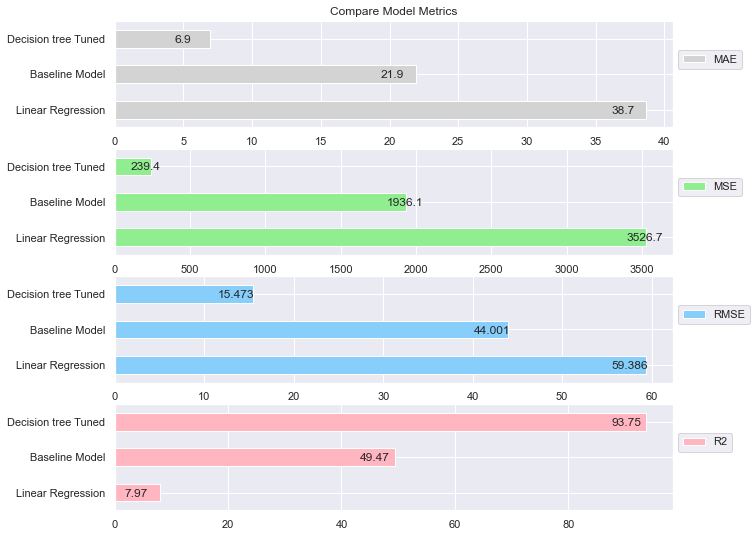

In [197]:
compare_model_metrics([linear_metrics,base_metrics,DT_metrics])

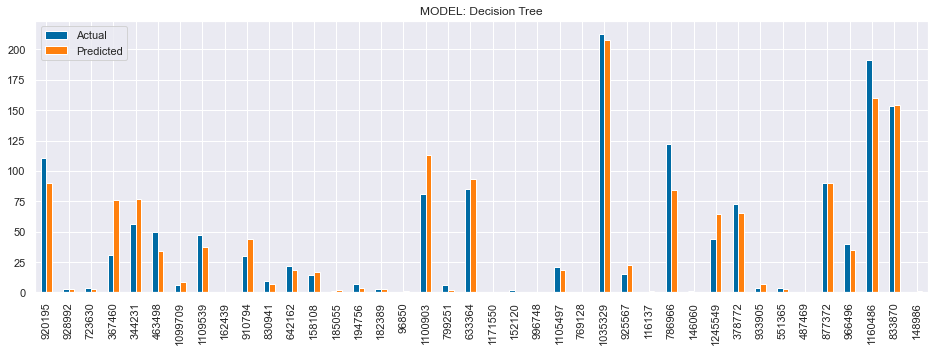

Text(0.5, 1.0, 'Decision tree: Actual vs Predicted')

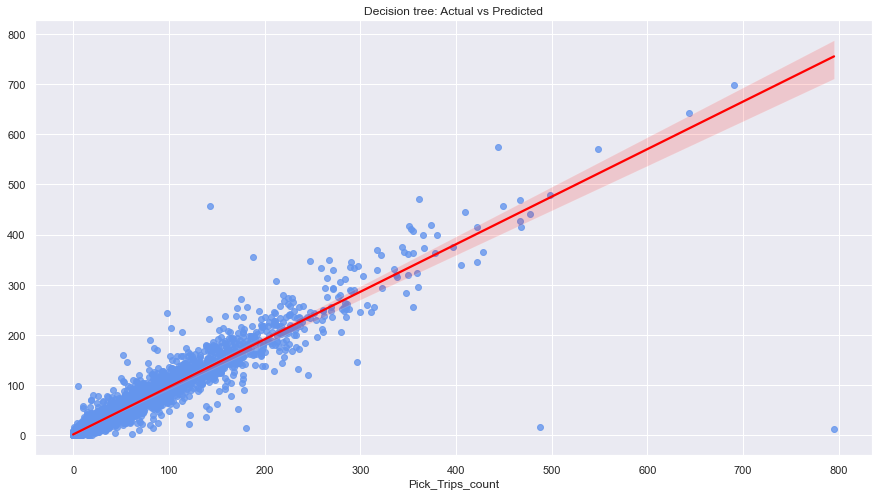

In [196]:
plot_real_vs_pred('Decision Tree', y_test, DT_tuned_y_pred)

sns.regplot(y_test.head(6000), DT_y_pred[:6000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision tree: Actual vs Predicted')

### Conclusion:

__The tuned decison tree is the best model so far, with R2 = 93.75% and the lowest error of 15.4 (RMSE).__

The predcition vs true value indicate how close the prediction from the true value and the regression plot indicate how strong is the correlation between the predictions and the true value

## Random Forest

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
# Fitting RF regression to the Training set
RF_regression = RandomForestRegressor(n_jobs=-1)
RF_regression.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [120]:
# Predicting the Test set results
RF_y_pred = RF_regression.predict(X_test)

In [122]:
RF_metrics = get_metrics('Random Forest',y_test, RF_y_pred)

MODEL:  Random Forest
MAE:  5.724271454406177
MSE:  147.5212939026605
RMSE:  12.145834425952813
R-Square (Coefficient of determination):  96.15  %


__We need to check if the model overfit or not, simple comparison between the train score and the test score can show us if the model is overfitted or not.__

- If the train score is 1, then the model is overfit

- If the gap between the train score and the test score is quit high, it means the model is overfit


_Lets explore the train score and the test score_

In [123]:
# training R2
np.round(RF_regression.score(X_train, y_train),4)

0.995

In [124]:
# test R2
np.round(RF_regression.score(X_test, y_test),4)

0.9615

Also it seems that the model is overfit since the training score is almost 1

In [257]:
cv=KFold(n_splits=5,shuffle=True)
# performing the KFold Cross-Validation
RF_CV=cross_val_score(RandomForestRegressor(n_jobs=-1),X, y,cv=cv)

In [258]:
print('CV average Random forest model score:',(RF_CV.mean())*100,'%')

CV average Random forest model score: 96.33272936862035 %


__Tuning the model__

we will tune the following parameters `n_estimators`, `max_depth`,`min_samples_leaf`

In [217]:
my_param_grid = {'n_estimators': [20,30,50], 
                 'max_depth':range(15,25,1),
                'min_samples_leaf':range(2,10,1)}

In [218]:
from sklearn.model_selection import RandomizedSearchCV

__To save time while we are tuning the hyperparameters we are going to use `RandomizedSearchCV`__

In [219]:
RF_tuned= RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),my_param_grid,cv = 3,scoring = "neg_mean_absolute_error")

In [220]:
RF_tuned.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': range(15, 25),
                                        'min_samples_leaf': range(2, 10),
                                        'n_estimators': [20, 30, 50]},
                   scoring='neg_mean_absolute_error')

In [221]:
RF_tuned_y_pred = RF_tuned.predict(X_test)

In [222]:
RF_metrics = get_metrics('Random Forest',y_test, RF_tuned_y_pred)

MODEL:  Random Forest
MSE:  147.6234533985106
RMSE:  12.150039234443263
R^2 (Coefficient of determination):  0.9614752765903242
R (Correlation coefficient):  0.9805556168972286


In [223]:
RF_tuned.best_params_

{'n_estimators': 50, 'min_samples_leaf': 2, 'max_depth': 23}

In [224]:
#RF_tuned.best_params_

In [125]:
# Fitting RF regression to the Training set
RF_regression_tuned = RandomForestRegressor(n_jobs=-1,n_estimators= 50, min_samples_leaf=2,max_depth=23)
RF_regression_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, min_samples_leaf=2, n_estimators=50,
                      n_jobs=-1)

In [126]:
RF_tuned_y_pred = RF_regression_tuned.predict(X_test)

In [127]:
RF_metrics = get_metrics('Random Forest',y_test, RF_tuned_y_pred)

MODEL:  Random Forest
MAE:  5.972137495192067
MSE:  161.18987163635938
RMSE:  12.696057326444276
R-Square (Coefficient of determination):  95.79  %


__Now we have more generalized model. The train score and test score are closed to each other__

In [128]:
# training R2
np.round(RF_regression_tuned.score(X_train, y_train),4)

0.9846

In [129]:
# training R2
np.round(RF_regression_tuned.score(X_test, y_test),4)

0.9579

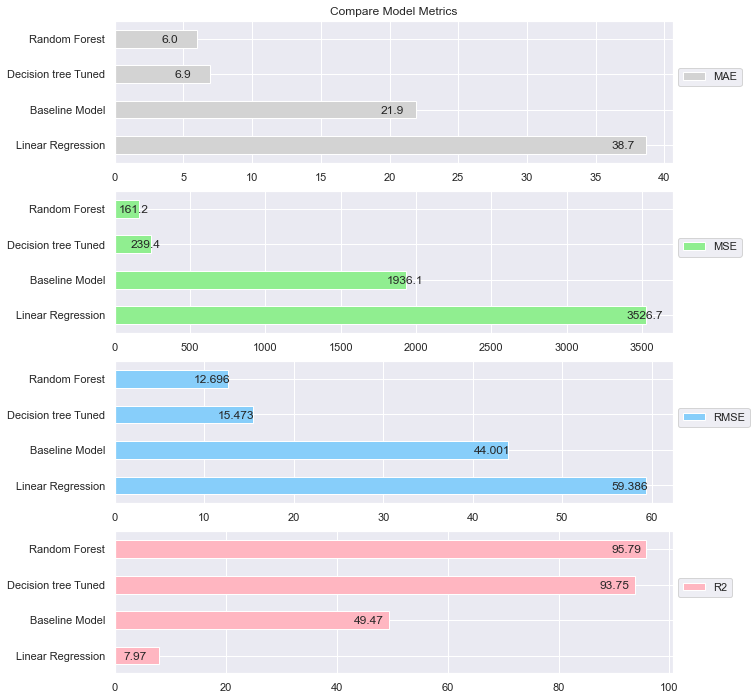

In [195]:
compare_model_metrics([base_metrics,linear_metrics,DT_metrics,RF_metrics])

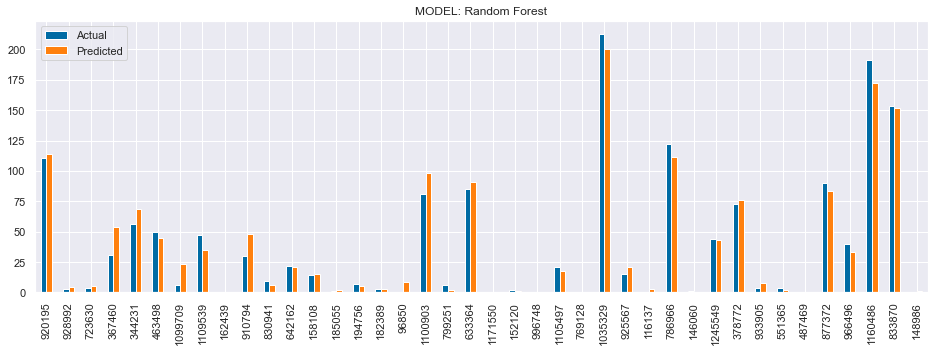

Text(0.5, 1.0, 'Decision tree: Actual vs Predicted')

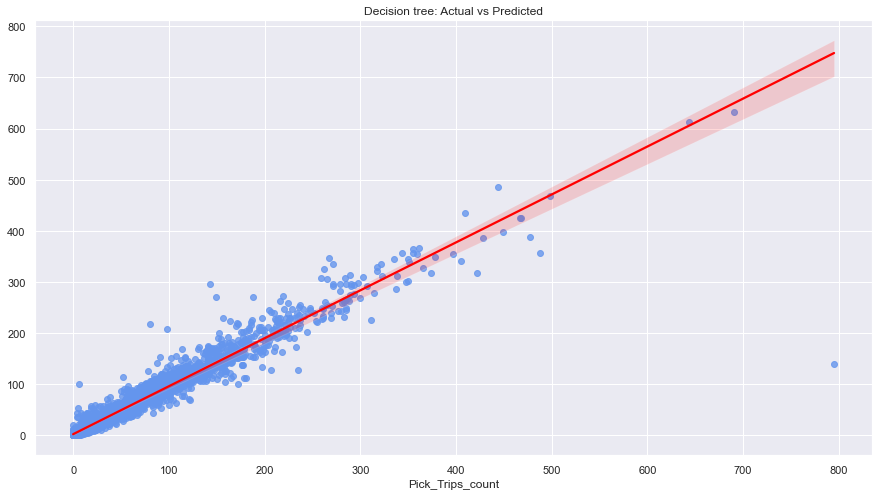

In [194]:
plot_real_vs_pred('Random Forest', y_test, RF_tuned_y_pred)

sns.regplot(y_test.head(5000), RF_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Decision tree: Actual vs Predicted')

### Conclusion:

__The tuned Random Forest is the best model so far, with R2 = 95.79% and the lowest error of 12.6 (RMSE).__

The predcition vs true value indicate how close the prediction from the true value and the regression plot indicate how strong is the correlation between the predictions and the true value

## 3- KNN regression

In [268]:
from sklearn.neighbors import KNeighborsRegressor

__Since KNN regression require the data to be scaled, then we are going to use the scaled training dataset__

In [62]:
# Fitting KNN regression to the Training set

KNN_regression = KNeighborsRegressor(n_neighbors=5)
KNN_regression.fit(scaled_X_train, y_train)

KNeighborsRegressor()

In [63]:
KNN_y_pred = KNN_regression.predict(scaled_X_test)

In [66]:
# training R2
np.round(KNN_regression.score(scaled_X_train, y_train),4)

0.5361

In [272]:
# test R2
np.round(KNN_regression.score(scaled_X_test, y_test),4)

0.3214

In [64]:
KNN_metrics = get_metrics('KNN',y_test, KNN_y_pred)

MODEL:  Random Forest
MSE:  2729.5272640548365
RMSE:  52.24487787386278
R^2 (Coefficient of determination):  0.28768579472926314
R (Correlation coefficient):  0.5566168979361121


__The KNN model have bad result, lets tune the K value using the elbow method__

In [68]:
RMSE_CV=[]
RMSE_test = []

k=15

for i in range(1,k):
    KNN_i = KNeighborsRegressor(n_neighbors=i)
    KNN_i.fit(scaled_X_train, y_train)
    RMSE_i = np.sqrt(np.mean(-1*cross_val_score(estimator = KNN_i, X = scaled_X_train, y = y_train, cv = 3 , scoring="neg_mean_squared_error" )))
    RMSE_CV.append(RMSE_i)
    
    RMSE_test.append(np.sqrt(np.mean(np.square(y_test - KNN_i.predict(scaled_X_test)))))
    
optimal_k = pd.DataFrame({'RMSE_CV': np.round(RMSE_CV,2), 'RMSE_test':np.round(RMSE_test,2)}, index=range(1,k))

In [72]:
optimal_k.head(15)

,RMSE_CV,RMSE_test
1,65.09,61.26
2,58.82,57.66
3,56.04,54.88
4,55.00,52.67
5,54.61,52.24
6,54.21,52.27
7,53.74,52.39
8,53.21,52.60
9,52.72,52.69
10,52.33,52.44


In [70]:
#best K value which have the lowest RMSE
np.argmin(optimal_k['RMSE_CV'])

13

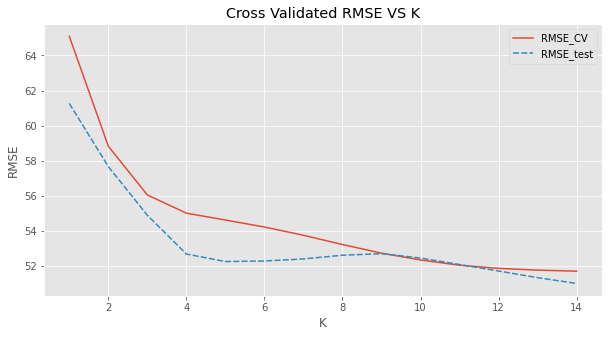

In [71]:
plt.figure(figsize=(10,5))
sns.lineplot(data=optimal_k)
plt.title('Cross Validated RMSE VS K')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

__As we can see, the best value for K is 14 which have the lowest RMSE value__

we are going to refill the KNN model with K=14

In [269]:
# Fitting KNN regression to the Training set

KNN_regression = KNeighborsRegressor(n_neighbors=14)
KNN_regression.fit(scaled_X_train, y_train)

KNeighborsRegressor(n_neighbors=14)

In [141]:
KNN_y_pred = KNN_regression.predict(scaled_X_test)

__Checking the model if it overfilt or not__

In [142]:
np.round(KNN_regression.score(scaled_X_train, y_train),4)

0.4068

In [143]:
# test R2
np.round(KNN_regression.score(scaled_X_test, y_test),4)

0.3214

In [144]:
KNN_metrics = get_metrics('KNN regression',y_test, KNN_y_pred)

MODEL:  KNN regression
MAE:  30.882842228647696
MSE:  2600.299669563393
RMSE:  50.99313355309118
R-Square (Coefficient of determination):  32.14  %


__From the performance metrics, we can see that KNN predictions are bad. the reason behind that is KNN is a distance-based algorithm, the cost of calculating distance between a new point and each existing point is very high which in turn degrades the performance of the algorithm.__

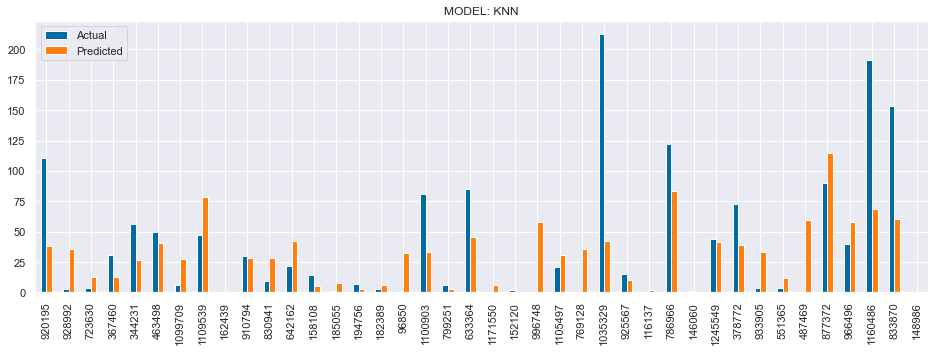

Text(0.5, 1.0, 'KNN: Actual vs Predicted')

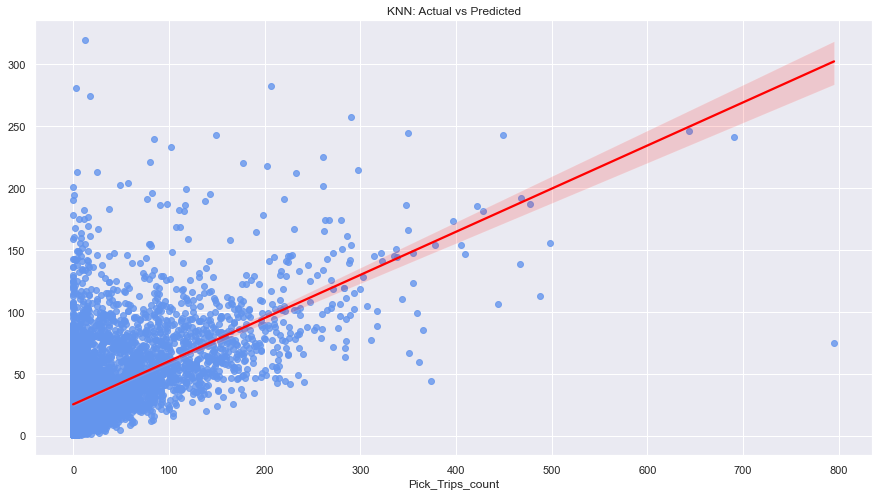

In [193]:
plot_real_vs_pred('KNN', y_test, KNN_y_pred)

sns.regplot(y_test.head(5000), KNN_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('KNN: Actual vs Predicted')

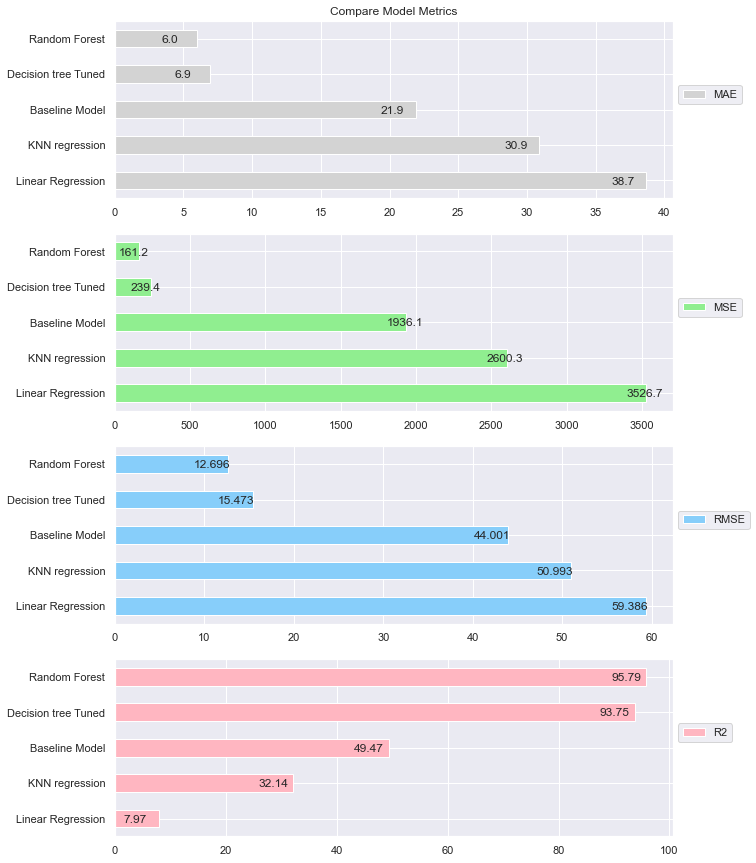

In [192]:
compare_model_metrics([base_metrics,linear_metrics,DT_metrics,RF_metrics,KNN_metrics])

### Conclusion:

__The KNN model predictions is bad and lower than the baseline model. this algorthim doesnt perform well in big dataset__ 

## 4- XGboost 

In [147]:
# Fitting SVM regression to the Training set
XGB_regression = XGBRegressor()

In [148]:
XGB_regression.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [149]:
XGB_pred = XGB_regression.predict(X_test)

In [150]:
xgb_metrics = get_metrics('XGB',y_test, XGB_pred)

MODEL:  XGB
MAE:  13.77662457596669
MSE:  582.5742990337586
RMSE:  24.136575959190207
R-Square (Coefficient of determination):  84.8  %


### Tuning the hyperparameter

we are going to tune the following hyperparameters `n_estimators`,`max_depth`,`learning_rate`,`min_child_weight`

In [238]:
hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

In [239]:
XGB_tuning = GridSearchCV(XGBRegressor(),
                       param_grid=hyperparameter_grid,
                       cv = 3,
                       scoring = "neg_mean_absolute_error")

In [240]:
XGB_tuning.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'min_child_weight': [1, 10, 100],
                         'n_estimators': [100, 400, 800]},
             scoring='neg_mean_absolute_error')

In [241]:
XGB_tuned_y_pred = XGB_tuning.predict(X_test)

In [243]:
XGBoost_tuned_metrics = get_metrics('XGBoost tuned',y_test, XGB_tuned_y_pred)

MODEL:  XGBoost tuned
MSE:  153.17670359121516
RMSE:  12.37645763501072
R^2 (Coefficient of determination):  0.960026066300404
R (Correlation coefficient):  0.9798769478732885


__The best tunned parameters values__

In [245]:
XGB_tuning.best_params_

{'learning_rate': 0.2,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 800}

In [151]:
# refilling regression tree to the Training set
XGB_regression = XGBRegressor(learning_rate=0.2,max_depth= 9,min_child_weight=1,n_estimators=800)
XGB_regression.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [152]:
XGB_y_pred = XGB_regression.predict(X_test)

In [154]:
XGB_metrics = get_metrics('XGB',y_test, XGB_y_pred)

MODEL:  XGB
MAE:  6.941283208095235
MSE:  153.17670359121516
RMSE:  12.37645763501072
R-Square (Coefficient of determination):  96.0  %


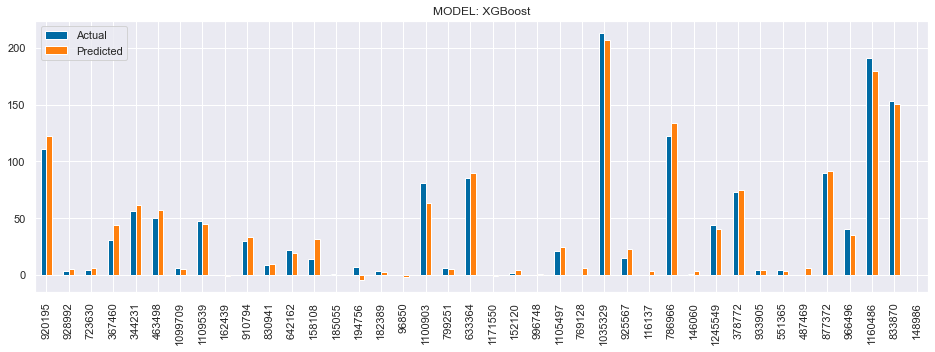

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

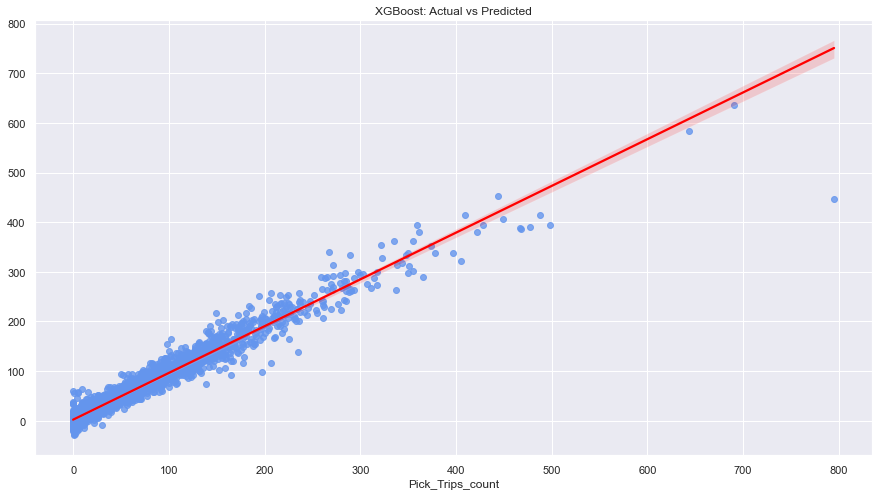

In [191]:
plot_real_vs_pred('XGBoost', y_test, XGB_y_pred)

sns.regplot(y_test.head(5000), XGB_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('XGBoost: Actual vs Predicted')

__We will perform K-fold cross validation to evaluate the model's ability when given new data__

we will choose 5 splits

In [252]:
cv=KFold(n_splits=5,shuffle=True)
# performing the KFold Cross-Validation
XGB_CV=cross_val_score(XGBRegressor(learning_rate=0.2,max_depth= 9,min_child_weight=1,n_estimators=800),X, y,cv=cv)

In [253]:
print('CV average XGBoost model score:',(XGB_CV.mean())*100,'%')

CV average XGBoost model score: 96.1016864754336 %


__The average score of this model when testing it on new data is similar and doesnt drop. which mean this model can work on any unseen data__

__We need to check if the model overfit or not, simple comparison between the train score and the test score can show us if the model is overfitted or not.__

- If the train score is 1, then the model is overfit

- If the gap between the train score and the test score is quit high, it means the model is overfit


_Lets explore the train score and the test score_

In [254]:
np.round(XGB_regression.score(X_train, y_train),4)

0.9791

In [255]:
np.round(XGB_regression.score(X_test, y_test),4)

0.96

__The model is not overfit__ Excellent!

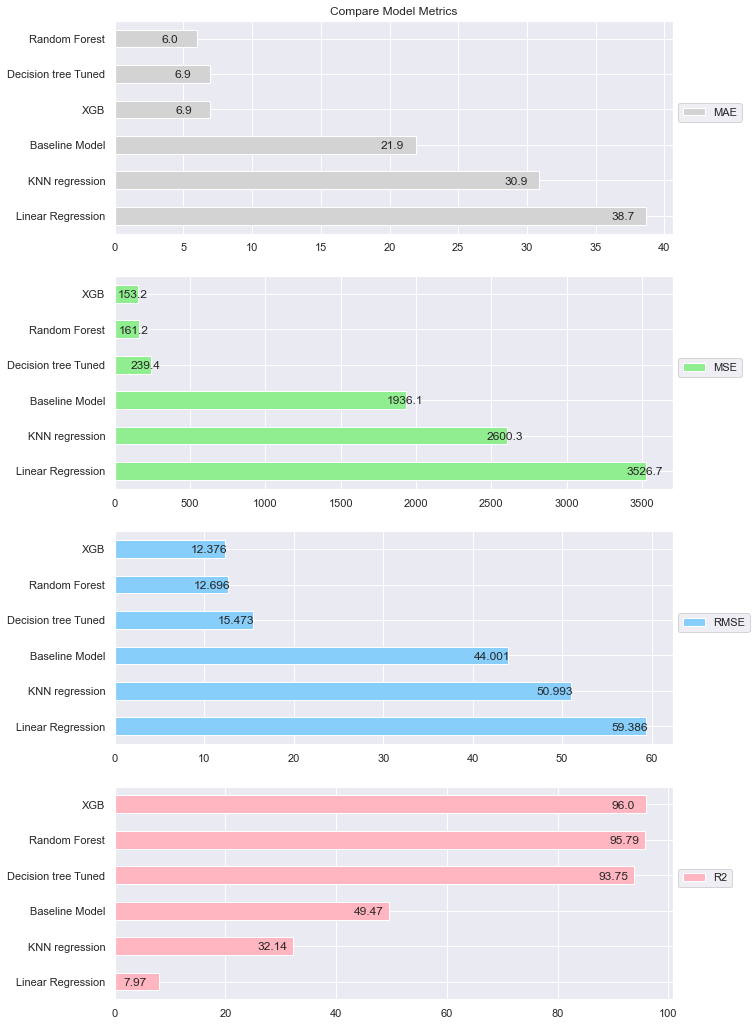

In [190]:
compare_model_metrics([base_metrics,linear_metrics,DT_metrics,RF_metrics,KNN_metrics,XGB_metrics])

### Conclusion:

__The tuned XGboost is the best model so far, with R2 = 96% and the lowest error of 12.3 (RMSE).__

The predcition vs true value indicate how close the prediction from the true value and the regression plot indicate how strong is the correlation between the predictions and the true value

## 5- Stacking Model

We will develop stacking model which will use the top 3 models we got so far hoping to get more accurate model. The stacked model consists of a combination of boosting and bagging 3 base learner models, namely Decision tree regressor, Random Forest regressor, and Xgboost regressor.

In [283]:
from sklearn.ensemble import StackingRegressor

In [284]:
estimators = [
    ('Decision Tree',Tree_regressor_tuned),
    ('Random Forest',RF_regression),
    ('XGboost',XGB_regression)
]

In [285]:
stack_model=StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

In [286]:
stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('Decision Tree',
                               DecisionTreeRegressor(max_depth=24,
                                                     min_samples_leaf=4)),
                              ('Random Forest',
                               RandomForestRegressor(n_jobs=-1)),
                              ('XGboost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,...
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.2, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=9,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=800, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0,
                                            reg_alpha=0, reg_lambda=1, ...))],
                  final_estimator=LinearRegression())

In [158]:
Stack_y_pred = stack_model.predict(X_test)

In [159]:
Stacked_metrics = get_metrics('Stacked model',y_test, Stack_y_pred)

MODEL:  Stacked model
MAE:  5.824010046033996
MSE:  125.51146672050632
RMSE:  11.203190024296934
R-Square (Coefficient of determination):  96.72  %


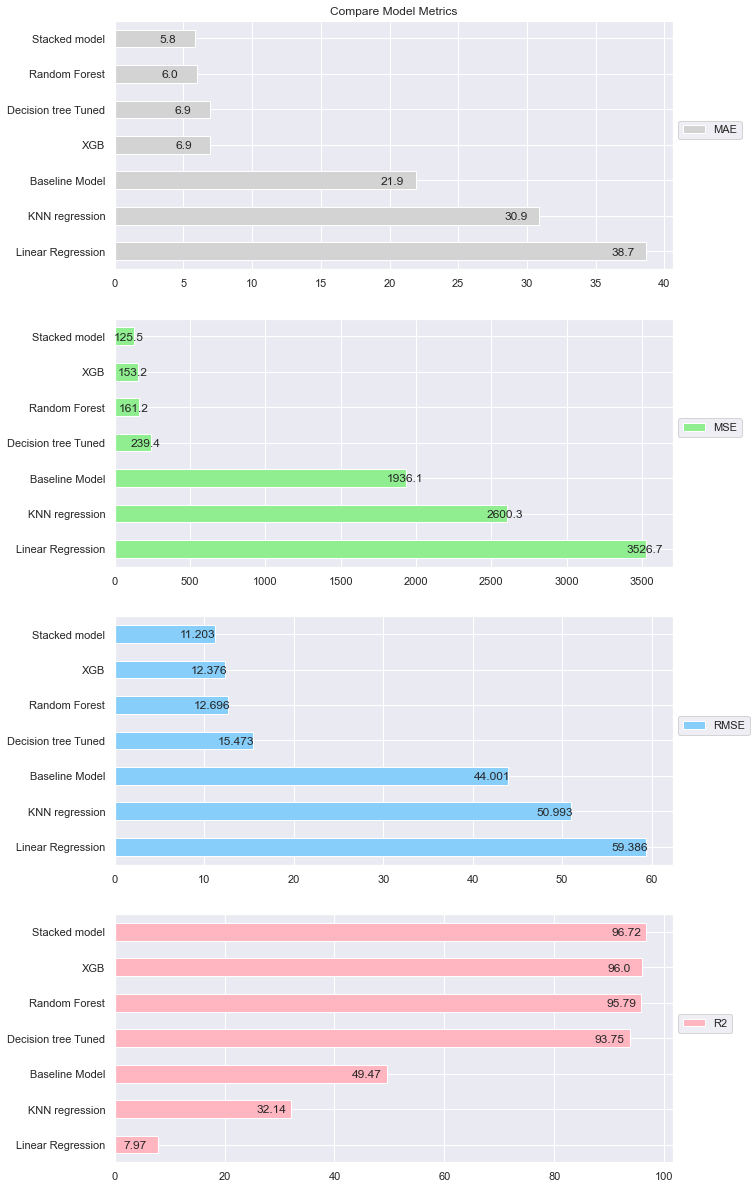

In [189]:
compare_model_metrics([base_metrics,linear_metrics,DT_metrics,RF_metrics,KNN_metrics,XGB_metrics,Stacked_metrics])

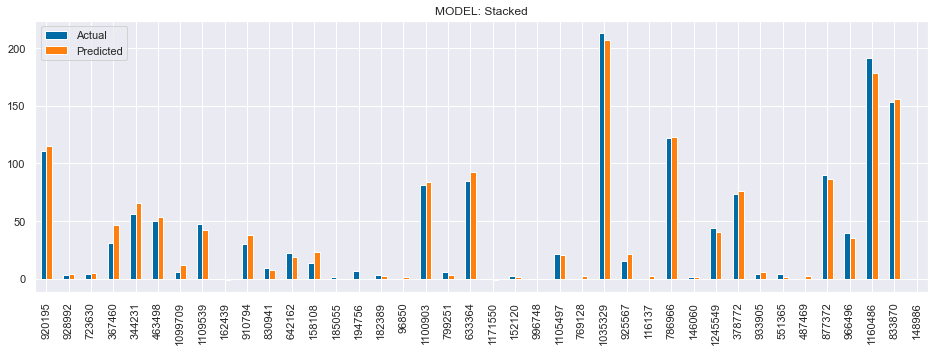

Text(0.5, 1.0, 'Stacked model: Actual vs Predicted')

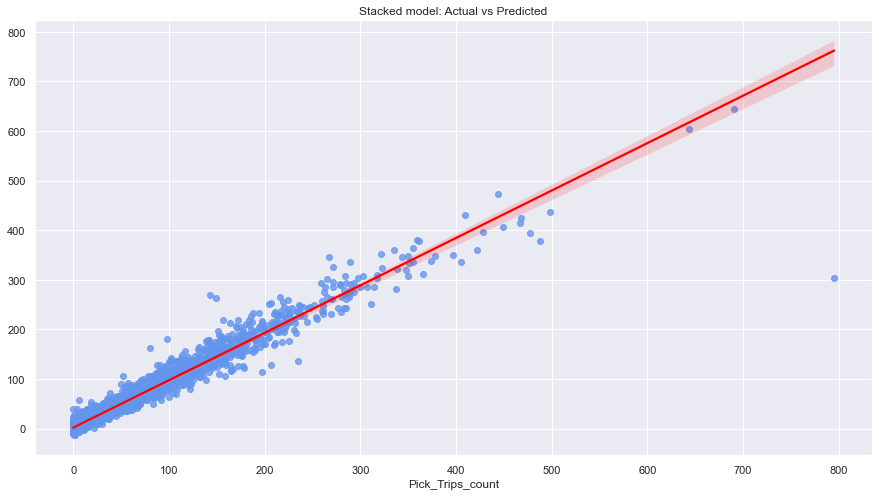

In [188]:
plot_real_vs_pred('Stacked', y_test, Stack_y_pred)

sns.regplot(y_test.head(5000), Stack_y_pred[:5000],
           scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}) \
            .set_title('Stacked model: Actual vs Predicted')

### Conclusion:

__The Stacked model is the best model so far, with R2 = 96.7% and the lowest error of 11.2 (RMSE).__

The stacked model outperfomed all the used models. We will save this model to use it in our forecasting application.

The predcition vs true value indicate how close the prediction from the true value and the regression plot indicate how strong is the correlation between the predictions and the true value

__We will save this model using pickle to use it in our forecasting application which we will develop later__

In [302]:
pickle.dump(stack_model, open('ML_model.pkl', 'wb'))

==============================================================================